In [30]:
%pip install pylatex pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd

df = pd.read_csv("measurements/reliable-results.csv")
df

,content_type,number_of_peers,opt_type,runtime_in_ms,success,objective,avg_delay
0,VIDEO,2,DIR,0.2387,1,128.0,45.8707
1,VIDEO,2,HEU,2.7246,1,128.0,45.8707
2,VIDEO,2,ILP,872.8333,1,128.0,45.8707
3,VIDEO,2,MST,12.6646,1,128.0,45.8707
4,VIDEO,8,DIR,0.0160,1,1145.0,54.3554
...,...,...,...,...,...,...,...
440,MESSAGING,37,HEU,45.0265,1,659.0,83.1730
441,MESSAGING,37,MST,13.1075,1,650.0,88.7611
442,MESSAGING,43,DIR,0.0598,1,8105.0,57.3500
443,MESSAGING,43,HEU,52.7501,1,658.0,85.2511


In [32]:
opt_data_by_content = {}

# Gather data for plotting
for content_type in df["content_type"].unique():
    content = df[df["content_type"] == content_type].sort_values(["number_of_peers"])
    data = content[["number_of_peers", "opt_type", "runtime_in_ms"]]

    peers = data["number_of_peers"].unique()
    dir_data = data[data["opt_type"] == "DIR"]["runtime_in_ms"].values
    heu_data = data[data["opt_type"] == "HEU"]["runtime_in_ms"].values
    ilp_data = data[data["opt_type"] == "ILP"]["runtime_in_ms"].values
    mst_data = data[data["opt_type"] == "MST"]["runtime_in_ms"].values

    # Adjust zero values in dir_data to 0.1 to avoid log(0)
    dir_data[dir_data <= 0.1] = 0.1

    # Put data together for plotting
    opt_data = {"DIR": dir_data, "HEU": heu_data, "ILP": ilp_data, "MST": mst_data}
    opt_data_by_content[content_type] = opt_data

print("Data for plotting:")
for content_type, opt_data in opt_data_by_content.items():
    print(content_type)
    for opt_type, data in opt_data.items():
        print(f"\t{opt_type}: {data[:3]} ...")

Data for plotting:
VIDEO
	DIR: [0.2387 0.2284 0.206 ] ...
	HEU: [2.7246 4.1025 7.1814] ...
	ILP: [  872.8333  2864.3878 14488.7249] ...
	MST: [12.6646 12.0437 11.4079] ...
AUDIO
	DIR: [0.1 0.1 0.1] ...
	HEU: [1.1144 2.1379 3.1312] ...
	ILP: [  954.1159  3241.8246 11468.5507] ...
	MST: [11.723  12.3029 10.9119] ...
MESSAGING
	DIR: [0.1 0.1 0.1] ...
	HEU: [1.2505 2.0866 3.0837] ...
	ILP: [ 1020.5193  3957.1826 19890.3637] ...
	MST: [12.3978 12.5198 11.7996] ...


In [64]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

NAMES = {
    "DIR": "Direct Link Tree",
    "HEU": "Multicast Heuristic",
    "ILP": "Integer Linear Programming",
    "MST": "Minimum Spanning Tree",
}

LATENCIES = {
    "VIDEO": 400,
    "AUDIO": 150,
    "MESSAGING": 1000,
    # "GAMING": 50,
}

def plot_runtime_vs_peers(opt_data_by_content):
    col_count = 3
    row_count = (len(opt_data_by_content) + col_count - 1) // col_count

    # Create the figure and grid specification
    fig = plt.figure(figsize=(6 * col_count, 5.5 * row_count))
    gs = GridSpec(row_count, col_count, width_ratios=[1] * col_count, wspace=0.25, hspace=0.25)

    for i, (content_type, opt_data) in enumerate(sorted(opt_data_by_content.items(), key=lambda x: LATENCIES[x[0]], reverse=True)):
        peers = range(1, len(opt_data["DIR"]) + 1)

        # Logarithmic scale subplot
        ax = fig.add_subplot(gs[i])
        ax.set_title(f"D = {LATENCIES[content_type]} ms")
        ax.set_yscale("log")
        ax.set_xlabel("Number of Peers")
        ax.set_ylabel("Runtime (ms)")
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax.set_ylim([0.1, 1e7])
        ax.set_xticks(peers)
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins="auto", integer=True))

        COLORED_MARKERS = [("black", "o"), ("blue", "p"), ("red", "s"), ("green", "^")]

        for (opt, data), (color, marker) in zip(opt_data.items(), COLORED_MARKERS):
            opt_name = NAMES[opt]
            peers_for_opt = peers[:len(data)]
            ax.plot(peers_for_opt, data, label=opt_name, color=color, marker=marker, linewidth=1.5)

        ax.legend(loc="upper right")

    # Show the plot
    plt.savefig(f"runtime_vs_peers.svg")

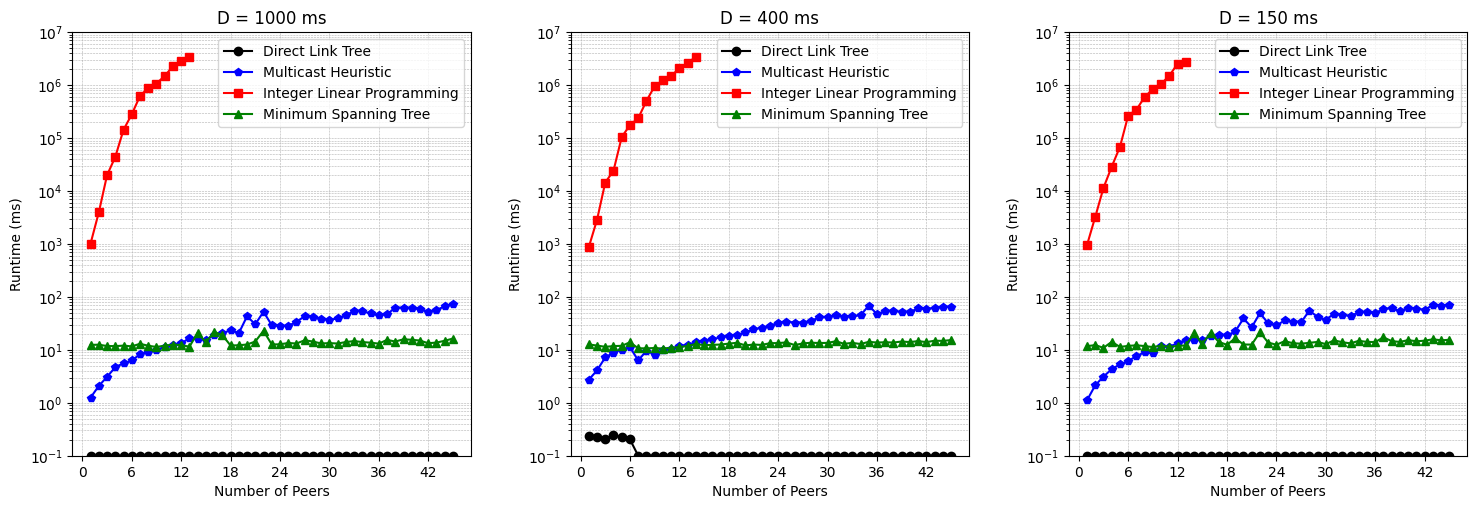

In [65]:
plot_runtime_vs_peers(opt_data_by_content)